### Apple & Intel Smartphone Modem Business Merger
- Apple Inc. has agreed to acquire the modem business of Intel for a consideration of $1 billion. 
- This includes all the intellectual property, physical property, equipment leases, and over 2200 employees. 
- It is said that Apple had made the decision to build a new modem in-house after the Qualcomm debacle.

In [81]:
# Initial imports
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import reuters, stopwords
from string import punctuation
import re
from nltk.tokenize import RegexpTokenizer
from plotly import graph_objects as go

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from newsapi import NewsApiClient
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Alleen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Read your api key environment variable
api_key = os.getenv("news_api")

In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key= "b6aebcb604f047158e475ebb1370a8bf")

In [4]:
articles = []

for i in range(1,20,1):
    articles_page = newsapi.get_everything(
            q="Apple & Intel Modem",
            #sources='abc-news-au, news-com-au',
            #domains='http://www.abc.net.au/news, http://www.news.com.au',
            from_param="2019-07-15",
            to="2019-08-15",
            language='en',
            sort_by="relevancy",
            page=i,
            page_size= 100)
    articles.extend(articles_page['articles'])

# outside of the loop, create the DataFrame
Apple= pd.DataFrame(articles)
Apple.tail()

,source,author,title,description,url,urlToImage,publishedAt,content
675,"{'id': None, 'name': 'CNET'}",Justin Jaffe,"iPhone 11, 11R and 11 Max: The specs, features...","With all the buzz about the 2020 iPhone, what ...",https://www.cnet.com/news/iphone-11-11r-11-max...,https://cnet1.cbsistatic.com/img/h7Zbcln-I1Pf0...,2019-08-07T18:32:05Z,Angela Lang/CNET\r\nWe're quite likely to see ...
676,"{'id': None, 'name': 'CNET'}",Justin Jaffe,"iPhone 11, 11R and 11 Max: The specs, features...","With all the buzz about the 2020 iPhone, what ...",https://www.cnet.com/news/iphone-11-11r-11-max...,https://cnet1.cbsistatic.com/img/h7Zbcln-I1Pf0...,2019-08-03T21:30:13Z,Angela Lang/CNET\r\nWe're quite likely to see ...
677,"{'id': None, 'name': 'BleepingComputer'}",,Malware Detected random five letters.exe unkno...,Malware Detected random five letters .exe unkn...,https://www.bleepingcomputer.com/forums/t/7018...,https://www.bleepingcomputer.com/forums/public...,2019-08-02T09:20:41Z,Windows 7 machine infected with some kind of v...
678,"{'id': None, 'name': 'BleepingComputer'}",,Malware Detected random five letters.exe unkno...,Malware Detected random five letters .exe unkn...,https://www.bleepingcomputer.com/forums/t/7018...,https://www.bleepingcomputer.com/forums/public...,2019-08-02T09:20:41Z,Windows 7 machine infected with some kind of v...
679,"{'id': None, 'name': 'CNET'}",Lynn La,"5G phones you can get now: Galaxy S10 5G, OneP...",The 5G revolution is rolling out now. Here are...,https://www.cnet.com/news/5g-phones-you-can-ge...,https://cnet4.cbsistatic.com/img/IsFA3Ii1BQVIu...,2019-07-18T11:00:09Z,Take your pick.\r\nAngela Lang/CNET\r\nIn addi...


### Preprocessing data 

In [5]:
# function to exatract just the name of the source of the news article and exclude other details
def source_getter(Apple):
    source = []
    for source_dict in Apple['source']:
        source.append(source_dict['name'])
    Apple['source'] = source #append the source to the df

In [6]:
#Extracts the source name from the source dictionary as seen above
source_getter(Apple)

In [7]:
#Dropping columns
Apple_df= Apple.drop(columns=['url','urlToImage','description'],axis=0)
Apple_df['publishedAt'] = pd.to_datetime(Apple_df['publishedAt']).dt.date
Apple_df.head()

,source,author,title,publishedAt,content
0,TechCrunch,Anthony Ha,Daily Crunch: Apple in talks to buy Intel mode...,2019-07-23,The Daily Crunch is TechCrunch’s roundup of ou...
1,TechCrunch,Anthony Ha,"Daily Crunch: Yep, Apple is buying Intel’s mod...",2019-07-26,The Daily Crunch is TechCrunch’s roundup of ou...
2,Ars Technica,Timothy B. Lee,Apple poised to acquire Intel’s smartphone mod...,2019-07-23,Enlarge/ Apple CEO Tim Cook.\r\n0 with 0 poste...
3,Ars Technica,Samuel Axon,Apple acquires Intel’s 5G smartphone modem bus...,2019-07-25,"Enlarge/ From left to right: the iPhone 8, the..."
4,Engadget,Richard Lawler,The Morning After: Google's Pixel sales double...,2019-07-26,Check out the engine cam video.SpaceX sends it...


In [8]:
#look for missing data
Apple_df.isnull().sum()

source          0
author         58
title           0
publishedAt     0
content         0
dtype: int64

### Applying Text Preprocessing steps: In the followting sections, some of the text preprocessing steps were applied to the data. The steps included:

- Tokenization
- Stop words removal
- Removing punctuations, apostrophe, special characters etc
- Lemmatize the text

In [100]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
stop = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
stop = stop.union({"going", "’","'s", "“","”", "would", "one", "also", "year", "company", "say", "said", "like", "deal", "``", "''", "could", "new", "New", "amp", "news", 
                   "-", "—", "two", "make", "including", "told", "get", "say", "even", "go", "people", "get", "much", "going", "since", "want", "made", 
                  "content", "time", "n't", "going", "still", "last", "think", "see", "way", "well", "know", "much","li","l","i"})


#Set tokenization function
def clean_text(text):
    
    words = word_tokenize(text)
    
    words = list(filter(lambda w:w.lower(), words))
 
    words = list(filter(lambda t:t not in punctuation, words))
    
    words = list(filter(lambda t: t.lower() not in stop, words))
    
    token = [lemmatizer.lemmatize(word) for word in words]
    
    return token

# Clean the text
# Create a function to clean the tweets
from spacy.lang.en.stop_words import STOP_WORDS
def prep_clean(text):

    text = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', text) # Remove emails
    text = re.sub(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)', '', text) # Remove urls
    text = re.sub(r'RT[\s]+', '', text) # Removing RT
    text = " ".join(text.split()) # Remove multiple space
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Removed @mentioned
    text = re.sub(r'#', '', text) # Removing the '#' symbol
    text = re.sub('[^A-Z a-z 0-9-]+', '', text) # Special characters or punctuation removal
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])

    return text

# Cleaning the text
Apple_df['content'] = Apple_df['content'].apply(lambda text: prep_clean(text))

# Show the cleaned text
Apple_df.head()

,source,author,title,publishedAt,content,token,date,Date
0,TechCrunch,Anthony Ha,Daily Crunch: Apple in talks to buy Intel mode...,2019-07-23,daily crunch techcrunchs roundup biggest impor...,"[Daily, Crunch, TechCrunch, roundup, biggest, ...",2019-11-29,2019-11-29
1,TechCrunch,Anthony Ha,"Daily Crunch: Yep, Apple is buying Intel’s mod...",2019-07-26,daily crunch techcrunchs roundup biggest impor...,"[Daily, Crunch, TechCrunch, roundup, biggest, ...",2019-12-02,2019-12-02
2,Ars Technica,Timothy B. Lee,Apple poised to acquire Intel’s smartphone mod...,2019-07-23,enlarge apple ceo tim cook 0 0 posters partici...,"[Enlarge/, Apple, CEO, Tim, Cook, 0, 0, poster...",2019-12-04,2019-12-04
3,Ars Technica,Samuel Axon,Apple acquires Intel’s 5G smartphone modem bus...,2019-07-25,enlarge left right iphone 8 iphone xs iphone x...,"[Enlarge/, left, right, iPhone, 8, iPhone, XS,...",2019-11-29,2019-11-29
4,Engadget,Richard Lawler,The Morning After: Google's Pixel sales double...,2019-07-26,check engine cam videospacex sends starhopper ...,"[Check, engine, cam, video.SpaceX, sends, 'Sta...",2019-11-25,2019-11-25


### Sentiment Analysis of News articles 

In [101]:
# Calculating the polarity of the news articles 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
results = []
for line in Apple_df['content'] :
    pol_score = analyzer.polarity_scores(line)
    pol_score['content'] = line
    results.append(pol_score)

In [102]:
# Creating a new dataframe of only the polarity score, the headline and the source of the news 
Apple_polarity = pd.DataFrame.from_records(results)
temp = []
for line in Apple_df['source'] :
    temp.append(line)
Apple_polarity['source'] =temp

In [103]:
# categorize news as positive or negative based on the compound score obtained
Apple_polarity['label'] = 'neutral'
# I have considered the news as positive if the compound score is greater than 0.05 hence the label 1
Apple_polarity.loc[Apple_polarity['compound'] > 0.05, 'label'] = 'positive'
# if the compound score is below -0.05 then it is considered negative 
Apple_polarity.loc[Apple_polarity['compound'] < -0.05, 'label'] = 'negative'
# word count of news headlines is calculated
Apple_polarity['word_count'] = Apple_polarity['content'].apply(lambda x: len(str(x).split()))

Apple_polarity.head()

,neg,neu,pos,compound,content,source,label,word_count
0,0.074,0.754,0.172,0.9749,daily crunch techcrunchs roundup biggest impor...,TechCrunch,positive,265
1,0.027,0.840,0.133,0.9694,daily crunch techcrunchs roundup biggest impor...,TechCrunch,positive,231
2,0.102,0.745,0.154,0.9300,enlarge apple ceo tim cook 0 0 posters partici...,Ars Technica,positive,273
3,0.040,0.773,0.186,0.9938,enlarge left right iphone 8 iphone xs iphone x...,Ars Technica,positive,325
4,0.049,0.795,0.156,0.9895,check engine cam videospacex sends starhopper ...,Engadget,positive,307


In [104]:
# Groupby Sentiment of the news
temp = Apple_polarity.groupby('label').count()['content'].reset_index().sort_values(by='content', ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,content
2,positive,606
0,negative,63
1,neutral,11


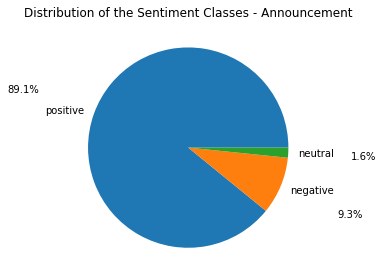

In [128]:
# Sentiment Distribution graph

plt.pie(temp.content, labels = temp.label, autopct= '%1.1f%%', pctdistance=1.75)
plt.title('Distribution of the Sentiment Classes - Announcement')
plt.tight_layout()
plt.show()

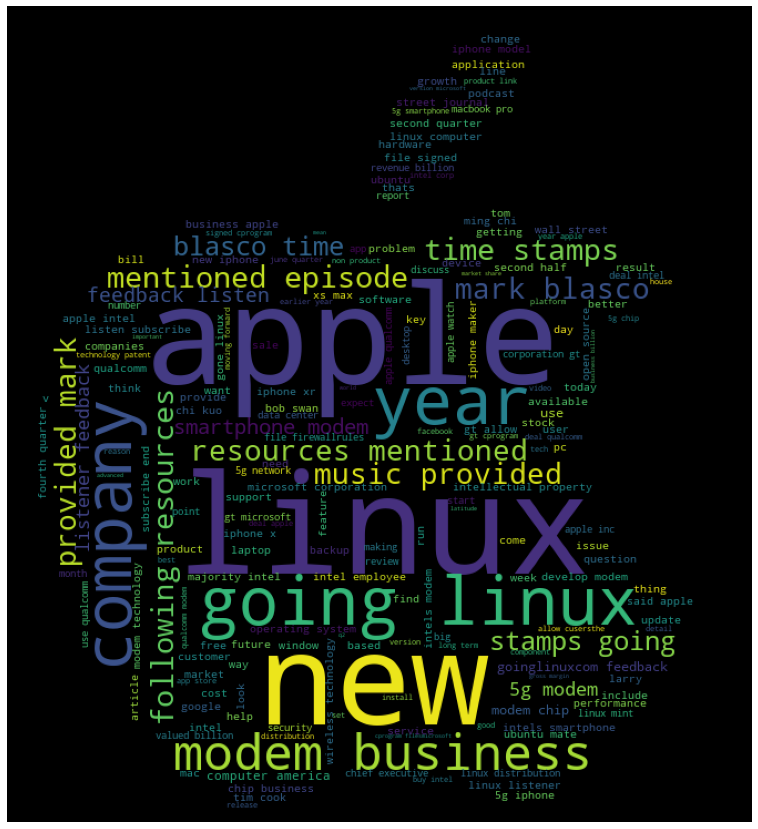

In [106]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from PIL import Image
data=Apple_df
mask = np.array(Image.open("apple-logo-black-white.jpg"))
wc = WordCloud( mask=mask, margin=1,max_font_size=125).generate(' '.join(data['content']))
plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.show()

### Analyzing the share market

In [18]:
import os
import pandas as pd
from datetime import datetime, timedelta
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

In [89]:
# Load .env enviroment variables
import yfinance as yf
Stock_df = yf.download("AAPL INTC", start="2019-07-15", end="2019-08-15",index_col='Date', parse_dates = True, infer_datetime_format = True)
Stock_df.head()

[*********************100%***********************]  2 of 2 completed


Adj Close                 Close                  High             \
                 AAPL       INTC       AAPL       INTC       AAPL       INTC   
Date                                                                           
2019-07-15  50.443680  48.018673  51.302502  50.119999  51.467499  50.250000   
2019-07-16  50.269142  47.108494  51.125000  49.169998  51.527500  50.000000   
2019-07-17  49.986462  47.319275  50.837502  49.389999  51.272499  49.700001   
2019-07-18  50.554291  47.846218  51.415001  49.939999  51.470001  49.990002   
2019-07-19  49.799641  48.162376  50.647499  50.270000  51.625000  50.660000   

                  Low                  Open               Volume            
                 AAPL       INTC       AAPL       INTC      AAPL      INTC  
Date                                                                        
2019-07-15  51.000000  49.770000  51.022499  50.000000  67789600  14345100  
2019-07-16  50.875000  48.959999  51.147499  49.910000  67467200  17131400  
2019-07-17  50.817501  49.240002  51.012501  49.500000  56430000  11928600  
2019-07-18  50.924999  48.889999  51.000000  49.279999  74162400  15671600  
2019-07-19  50.590000  49.910000  51.447498  49.959999  83717200  29141100

<AxesSubplot:title={'center':'Trading Volume'}, xlabel='Date'>

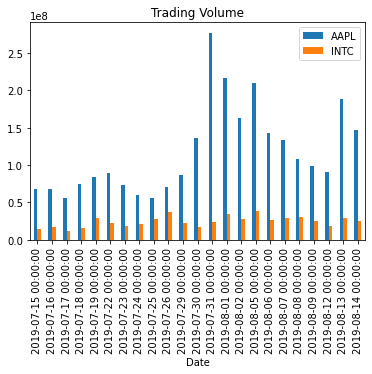

In [90]:
import hvplot.pandas
Stock_df['Volume'].plot.bar(title="Trading Volume")

### KEY TAKEAWAYS
- Volume measures the number of shares traded in a stock or contracts traded in futures or options.
- High volume means greater reliance can be placed on the movement in price than if there was low volume, because heavy volume is the relative consensus of a large number of participants.
- High volume is also attributable to a market top when strong buyer interest exists.
- Low volume often exists during an unsettled period, such as at a market bottom.  Low volume reflects a lack of confidence that is usually indicative of a consolidation period when prices are within a sideways trading range.

In [130]:
Stock_df['Close'].hvplot.line(title="Apple-Intel Stock Price")


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

### Closure of Deal

In [22]:
articles_close = []

for i in range(1,20,1):
    articles_page = newsapi.get_everything(
            q="Apple & Intel Modem",
            #sources='abc-news-au, news-com-au',
            #domains='http://www.abc.net.au/news, http://www.news.com.au',
            from_param="2019-11-23",
            to="2019-12-23",
            language='en',
            sort_by="relevancy",
            page=i,
            page_size= 100)
    articles_close.extend(articles_page['articles'])

# outside of the loop, create the DataFrame
Apple_close= pd.DataFrame(articles_close)
Apple_close.tail()

,source,author,title,description,url,urlToImage,publishedAt,content
195,"{'id': None, 'name': 'Hot Hardware'}",Brandon Hill,MediaTek Unleashes 7nm Dimensity 1000 SoC With...,"Yesterday, we revealed that Intel and MediaTek...",https://hothardware.com/news/mediatek-unleashe...,https://images.hothardware.com/contentimages/n...,2019-11-26T16:40:00Z,"Yesterday, we revealed that Intel and MediaTek..."
196,"{'id': None, 'name': 'Hot Hardware'}",Shane McGlaun,Qualcomm Says Priority Number One With Apple I...,Today 5G mobile networks are only offered in a...,https://hothardware.com/news/qualcomm-apple-5g...,https://images.hothardware.com/contentimages/n...,2019-12-05T16:27:00Z,Today 5G mobile networks are only offered in a...
197,"{'id': None, 'name': 'Fossbytes'}",Charanjeet Singh,"Apple iPhone 12 Release Date, Rumours | Everyt...",The popular belief is Apple iPhone 2020 will r...,https://fossbytes.com/apple-iphone-12-rumours/,https://fossbytes.com/wp-content/uploads/2019/...,2019-12-11T11:29:42Z,"Three years ago, Apple released the iPhone 10 ..."
198,"{'id': None, 'name': 'PCMag.com'}",Sascha Segan,"Inside Qualcomm's Snapdragon 865, Which Turns ...",The Qualcomm Snapdragon 865 will power the Sam...,https://www.pcmag.com/news/372333/inside-qualc...,https://assets.pcmag.com/media/images/676905-q...,2019-12-04T18:50:00Z,(Qualcomm's Snapdragon 865 reference phone)\r\...
199,"{'id': None, 'name': 'Kernel.org'}",Ingo Molnar,Merge tag 'perf-urgent-for-mingo-5.5-20191216'...,None,https://git.kernel.org/pub/scm/linux/kernel/gi...,None,2019-12-17T11:28:02Z,Pull perf/urgent fixes:\r\nperf top:\r\nArnald...


### Preprocessing data 

In [23]:
# function to exatract just the name of the source of the news article and exclude other details
def source_getter(Apple_close):
    source = []
    for source_dict in Apple_close['source']:
        source.append(source_dict['name'])
    Apple_close['source'] = source #append the source to the df

In [24]:
#Extracts the source name from the source dictionary as seen above
source_getter(Apple_close)

In [25]:
#Dropping columns
Apple_close_df= Apple_close.drop(columns=['url','urlToImage','description'],axis=0)
Apple_close_df['publishedAt'] = pd.to_datetime(Apple_close_df['publishedAt']).dt.date
Apple_close_df.head()

,source,author,title,publishedAt,content
0,TechCrunch,Darrell Etherington,Intel says Qualcomm’s business practices drove...,2019-11-29,It’s not like this wasn’t among the reasons ev...
1,Gizmodo.com,Sam Rutherford,Intel's Officially Out of the Smartphone Modem...,2019-12-02,"After first announcing a deal back in July, In..."
2,MacRumors,Juli Clover,Qualcomm President: Priority Number One is Lau...,2019-12-04,Apple and Qualcomm are working to launch a new...
3,Business Insider,"feedback@businessinsider.com (Hirsh Chitkara),...",Intel is looking to streamline operations by s...,2019-11-29,Semiconductor giant Intel is reportedly lookin...
4,Slashdot.org,msmash,Intel and MediaTek Partner on 5G Laptops for 2021,2019-11-25,The Fine Print: The following comments are own...


In [138]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
stop_close = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
stop_close = stop.union({"going", "’","'s", "“","”", "would", "one", "also", "year", "company", "say", "said", "like", "deal", "``", "''", "could", "new", "New", "amp", "news", 
                   "-", "—", "two", "make", "including", "told", "get", "say", "even", "go", "people", "get", "much", "going", "since", "want", "made", 
                  "content", "time", "n't", "going", "still", "last", "think", "see", "way", "well", "know", "much","li","static void","header","static","void","use","define","rw","r","w"})


#Set tokenization function
def clean_text(text):
    
    words = word_tokenize(text)
    
    words = list(filter(lambda w:w.lower(), words))
 
    words = list(filter(lambda t:t not in punctuation, words))
    
    words = list(filter(lambda t: t.lower() not in stop, words))
    
    token_close = [lemmatizer.lemmatize(word) for word in words]
    
    return token_close

# Clean the text
# Create a function to clean the tweets
from spacy.lang.en.stop_words import STOP_WORDS
def prep_clean(text):

    text = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', text) # Remove emails
    text = re.sub(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)', '', text) # Remove urls
    text = re.sub(r'RT[\s]+', '', text) # Removing RT
    text = " ".join(text.split()) # Remove multiple space
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Removed @mentioned
    text = re.sub(r'#', '', text) # Removing the '#' symbol
    text = re.sub('[^A-Z a-z 0-9-]+', '', text) # Special characters or punctuation removal
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])

    return text

# Cleaning the text
Apple_close_df['content'] = Apple_close_df['content'].apply(lambda text: prep_clean(text))

# Show the cleaned text
Apple_close_df.head()

,source,author,title,publishedAt,content,token_close
0,TechCrunch,Darrell Etherington,Intel says Qualcomm’s business practices drove...,2019-11-29,like wasnt reasons suspected apple suddenly an...,"[among, reason, everywhere, suspected, Apple, ..."
1,Gizmodo.com,Sam Rutherford,Intel's Officially Out of the Smartphone Modem...,2019-12-02,announcing deal july intel finally getting sma...,"[first, announcing, back, July, Intel, finally..."
2,MacRumors,Juli Clover,Qualcomm President: Priority Number One is Lau...,2019-12-04,apple qualcomm working launch new 5g iphone fa...,"[Apple, Qualcomm, working, launch, 5G, iPhone,..."
3,Business Insider,"feedback@businessinsider.com (Hirsh Chitkara),...",Intel is looking to streamline operations by s...,2019-11-29,semiconductor giant intel reportedly looking b...,"[Semiconductor, giant, Intel, reportedly, look..."
4,Slashdot.org,msmash,Intel and MediaTek Partner on 5G Laptops for 2021,2019-11-25,fine print following comments owned posted res...,"[Fine, Print, following, comment, owned, whoev..."


### Sentiment Analysis of News articles on Closure of deal

In [109]:
# Calculating the polarity of the news articles 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Initialize the VADER sentiment analyzer
analyzer_close = SentimentIntensityAnalyzer()
results_close = []
for line in Apple_close_df['content'] :
    pol_score_close = analyzer_close.polarity_scores(line)
    pol_score_close['content'] = line
    results_close.append(pol_score_close)

In [110]:
# Creating a new dataframe of only the polarity score, the headline and the source of the news 
Apple_close_polarity = pd.DataFrame.from_records(results_close)
temp_close = []
for line in Apple_close_df['source'] :
    temp_close.append(line)
Apple_close_polarity['source'] =temp_close

In [111]:
# categorize news as positive or negative based on the compound score obtained
Apple_close_polarity['label'] = 'neutral'
# I have considered the news as positive if the compound score is greater than 0.05 hence the label 1
Apple_close_polarity.loc[Apple_close_polarity['compound'] > 0.05, 'label'] = 'positive'
# if the compound score is below -0.05 then it is considered negative 
Apple_close_polarity.loc[Apple_close_polarity['compound'] < -0.05, 'label'] = 'negative'
# word count of news headlines is calculated
Apple_close_polarity['word_count'] = Apple_close_polarity['content'].apply(lambda x: len(str(x).split()))

Apple_close_polarity.head()

,neg,neu,pos,compound,content,source,label,word_count
0,0.100,0.746,0.155,0.8769,like wasnt reasons suspected apple suddenly an...,TechCrunch,positive,202
1,0.044,0.825,0.131,0.9423,announcing deal july intel finally getting sma...,Gizmodo.com,positive,176
2,0.035,0.816,0.149,0.9861,apple qualcomm working launch new 5g iphone fa...,MacRumors,positive,290
3,0.025,0.877,0.099,0.9719,semiconductor giant intel reportedly looking b...,Business Insider,positive,379
4,0.000,0.594,0.406,0.4767,fine print following comments owned posted res...,Slashdot.org,positive,8


In [112]:
# Groupby Sentiment of the news
temp_close = Apple_close_polarity.groupby('label').count()['content'].reset_index().sort_values(by='content', ascending=False)
temp_close.style.background_gradient(cmap='Purples')

,label,content
2,positive,160
0,negative,34
1,neutral,6


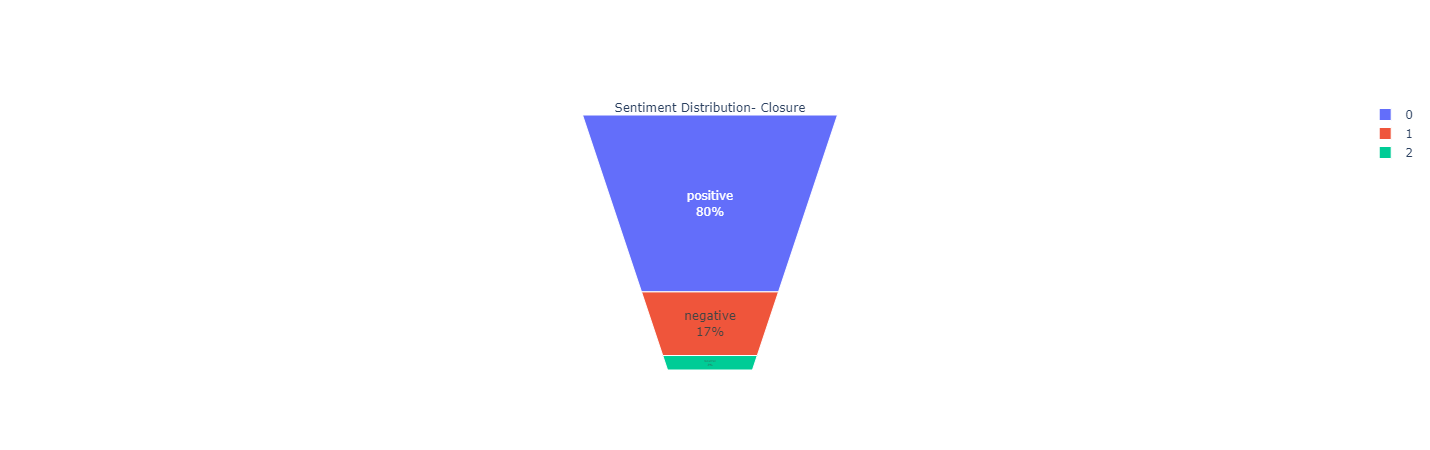

In [132]:
# Sentiment Distribution graph

fig = go.Figure(go.Funnelarea(
    text = temp_close.label,
    values = temp_close.content,
    title = 'Sentiment Distribution- Closure'
))

fig.show()

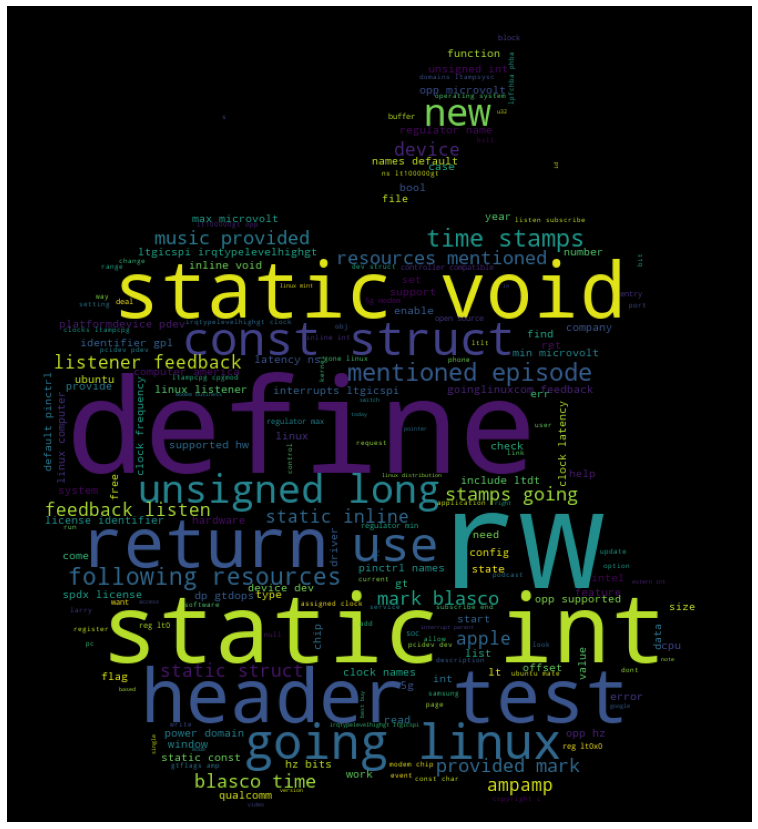

In [141]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
data=Apple_close_df
mask = np.array(Image.open("apple-logo-black-white.jpg"))
xc = WordCloud( mask=mask, margin=1,max_font_size=125).generate(' '.join(data['content']))
plt.figure(figsize=(15,15))
plt.imshow(xc)
plt.axis("off")
plt.show()

### Analyzing the share market

In [96]:
# Load .env enviroment variables
import yfinance as yf
Stock_close_df = yf.download("AAPL INTC", start="2019-11-23", end="2019-12-23",
                       progress=False,
                       index_col ='Date',
                       infer_datetime_format= True,
                       parse_dates = True)
Stock_close_df.head()

Adj Close                 Close                  High             \
                 AAPL       INTC       AAPL       INTC       AAPL       INTC   
Date                                                                           
2019-11-25  65.923813  57.036945  66.592499  58.810001  66.610001  58.840000   
2019-11-26  65.409035  57.124233  66.072502  58.900002  66.790001  59.130001   
2019-11-27  66.287636  56.745983  66.959999  58.509998  66.995003  58.590000   
2019-11-29  66.141602  56.299854  66.812500  58.049999  67.000000  58.299999   
2019-12-02  65.376869  55.921612  66.040001  57.660000  67.062500  58.689999   

                  Low                  Open                Volume            
                 AAPL       INTC       AAPL       INTC       AAPL      INTC  
Date                                                                         
2019-11-25  65.629997  58.000000  65.677498  58.000000   84020400  15011700  
2019-11-26  65.625000  58.450001  66.735001  58.950001  105207600  22338700  
2019-11-27  66.327499  57.910000  66.394997  58.529999   65235600  18184200  
2019-11-29  66.474998  57.790001  66.650002  58.150002   46617600   9481100  
2019-12-02  65.862503  57.470001  66.817497  58.549999   94487200  19154500

<AxesSubplot:title={'center':'Trading Volume'}, xlabel='Date'>

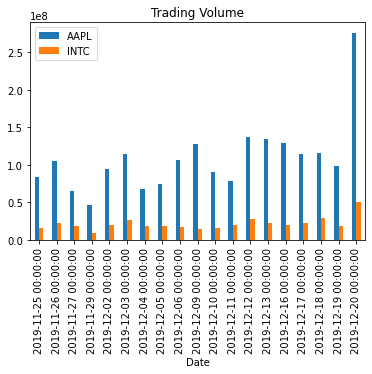

In [97]:
Stock_close_df['Volume'].plot.bar(title="Trading Volume")

In [135]:
Stock_close_df['Close'].hvplot.line(title="Apple-Intel Stock Price")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)